# Image Multiclassification with Keras: Planet understanding the amazon from space

En este notebook se encuentra el código del modelo realizado utilizando las funciones de la librería Keras de Tensorflow. Primero se han procesado y preparado los datos. Despues, se ha definido el arquitectura que va a tener el modelo. A continuación, se ha entrenado el modelo con nuestro dataset. Y, por último se ha realizado la evaluación.

## IMPORTS:

In [4]:
import tensorflow.keras
#keras.__version__
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
import pandas as pd
import tqdm
import numpy as np
#import cv2
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import models
from keras import layers
from tensorflow.keras.applications import resnet
from tqdm import tqdm
import os
from matplotlib import pyplot as plt

## Procesamiento de datos:

Se han tenido bastantes problemas a la hora de procesar los datos debido a como estaban estructurados y porque nosotros teníamos un problema de multiclasificación. 

Como se ha comentado anteriormente en el análisis exploratorio, se tenía un csv que contenía una columna con el nombre de las imágenes y otra con los levels. 

Para adaptar las especificaciones de los argumentos de la función de Keras que generaba y procesaba 
**(train_datagen.flow_from_dataframe)** se ha tenido que cambiar el csv de train.

In [ ]:
train = pd.read_csv("../data/csv_tags/train_v2.csv")

In [ ]:
train['tags'] = train['tags'].str.split(' ')

In [ ]:
TAGS = [
    "agriculture",
    "artisinal_mine",
    "bare_ground",
    "blooming",
    "blow_down",
    "clear",
    "cloudy",
    "conventional_mine",
    "cultivation",
    "habitation",
    "haze",
    "partly_cloudy",
    "primary",
    "road",
    "selective_logging",
    "slash_burn",
    "water",
]

In [ ]:
def comprobar(df,TAGS):
    for i in range(len(df)):
        tags = df.iloc[i,1]
        for t in tags:
            train[t][i] = 1

In [ ]:
comprobar(train,TAGS)

In [ ]:
training_data = train.sample(frac=0.8, random_state=25)
validating_data = train.drop(training_data.index)

A pesar de todo este procesamiento, da error cuando se ejecuta las funciones de Keras para procesar y generar los datos. El código era el siguiente.

``` from keras.preprocessing.image import ImageDataGenerator```

```train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')```

```# Note that the validation data should not be augmented!```
```test_datagen = ImageDataGenerator(rescale=1./255)```

```train_generator = train_datagen.flow_from_dataframe(
        training_data,
        path_train,
        x_col='image_name', y_col=TAGS,
        # This is the target directory
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='multi_output')```

```validation_generator = test_datagen.flow_from_dataframe(
        validating_data,
        path_train,
        x_col='image_name', y_col=TAGS,
        target_size=(150, 150),
        batch_size=20,
        class_mode='multi_output')```

También se habia intentado guardar las imágenes en carpetas según sus respectivos labels.

```path_validation ="../data/validation_fotos" ```

```path_train ="../data/train_fotos" ```

In [ ]:
def guardar_en_carpetas(path,df):
    l2 = []
    for foto,label in df.values:
        path_fotos="../data/train_jpg"
        for l in label:
            if not os.path.exists(f"{path}/{l}"): os.mkdir(f"{path}/{l}")
            if not os.path.exists( f"{path_train}/{foto}"): l2.append(foto)
      #shutil.move(f"{path_fotos}/{foto}.jpg", f"{path}/{foto}.jpg")
      #if os.path.exists(f"{path}/{foto}"): print("bien!")
    return l2

```fotos_no1 = guardar_en_carpetas(path_validation,validating_data)```

```fotos_no2 = guardar_en_carpetas(path_train,training_data)```

Tampoco en este caso hemos conseguido que funcionara el código de Keras adaptado para que coja las imágenes desde el directorio.

Al final, se decidió que en lugar de procesar imágenes, se procesaría los vectores de las imágenes. Para la variable de y_train se ha definido con label_map.

In [5]:
path_x_train = "../data/x_train.npy"
path_y_train = "../data/y_train.npy"

if not os.path.exists(path_x_train) and not os.path.exists(path_y_train):
    x_train = []
    x_test = []
    y_train = []
    
    df_train = pd.read_csv('../data/csv_tags/train_v2.csv')
    
    flatten = lambda l: [item for sublist in l for item in sublist]
    labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))
    
    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}
    
    for f, tags in tqdm(df_train.values, miniters=1000):
        img = cv2.imread('../data/train-jpg/{}.jpg'.format(f))
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 
        x_train.append(cv2.resize(img, (32, 32)))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    x_train = np.array(x_train, np.float16) / 255.
    
    print(x_train.shape)
    print(y_train.shape)
    
    with open(path_x_train, 'wb') as f:
        np.save(f, x_train)
    with open(path_y_train, 'wb') as f:
        np.save(f, y_train)

Se carga los array de y_train y x_train.

In [24]:
with open('../data/x_train.npy', 'rb') as f:
    x_train = np.load(f)
with open('../data/y_train.npy', 'rb') as f:
    y_train = np.load(f)

In [7]:
x_train

array([[[[0.4119, 0.4353, 0.3765],
         [0.408 , 0.4353, 0.3687],
         [0.4158, 0.4392, 0.3804],
         ...,
         [0.392 , 0.4392, 0.3647],
         [0.4   , 0.4236, 0.357 ],
         [0.4   , 0.4197, 0.357 ]],

        [[0.408 , 0.4158, 0.3608],
         [0.4038, 0.4392, 0.353 ],
         [0.4038, 0.4314, 0.357 ],
         ...,
         [0.4119, 0.443 , 0.349 ],
         [0.396 , 0.4197, 0.3372],
         [0.392 , 0.4197, 0.3372]],

        [[0.4   , 0.4236, 0.3608],
         [0.4038, 0.4236, 0.357 ],
         [0.4119, 0.4236, 0.349 ],
         ...,
         [0.4   , 0.4197, 0.353 ],
         [0.4038, 0.4275, 0.3452],
         [0.3882, 0.4119, 0.349 ]],

        ...,

        [[0.4119, 0.4275, 0.357 ],
         [0.408 , 0.4197, 0.3687],
         [0.4197, 0.4392, 0.3687],
         ...,
         [0.4158, 0.4314, 0.3647],
         [0.4038, 0.4314, 0.353 ],
         [0.408 , 0.4314, 0.3726]],

        [[0.4119, 0.4314, 0.3608],
         [0.4158, 0.4314, 0.3726],
         [0.

Aqui, se separa los datos en train, test y validation.

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

x_train, x_val, y_train, y_val  = train_test_split(x_train, y_train, test_size=0.2, random_state=1) 

In [26]:
print(len(x_train) , len(x_val) , len(x_test))

29144 7287 4048


## Arquitectura del modelo:

Nuestro modelo se ha realizado a partir de un modelo base de ResNet50. A ese modelo se le ha añadido una capa de Flatten y dos de Dense.

Hemos probado dos input_size (82,82) y (32,32). Entendemos que tendrá que dar mejor resultado el size más pequeño ya que el modelo aprende más facil. Aun asi, los resultados no lo reflejan.

In [28]:
conv_base = resnet.ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(82, 82, 3))

In [12]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [29]:
model = models.Sequential()
#model.add(BatchNormalization(input_shape=(82, 82,3)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(17, activation='sigmoid'))

This is what our model looks like now:

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 17)                4369      
                                                                 
Total params: 24,116,625
Trainable params: 24,063,505
Non-trainable params: 53,120
_________________________________________________________________


In [17]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 216


In [19]:
conv_base.trainable = False

In [20]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


# Entrenar el modelo con nuestro Dataset

Se ha definido la variable callbacks para definir el Early Stopping y para que guarde los weights.

In [22]:
history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ModelCheckpoint(filepath='../data/weights.best.hdf5', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='auto')]

Ahora, es el momento de entrenar el modelo. Se ha utilizado el optamizer de Adam y al final, nos hemos quedado con un LR de 1e-2

In [30]:
model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['accuracy'])
              
model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_val, y_val),
          callbacks = callbacks)

Epoch 1/10


2022-04-21 18:04:31.350457: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2351571072 exceeds 10% of free system memory.


228/228 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.7057
Epoch 1: val_loss did not improve from 0.24412
228/228 [==============================] - 576s 2s/step - loss: 0.1498 - accuracy: 0.7057 - val_loss: 0.5232 - val_accuracy: 0.0060
Epoch 2/10
228/228 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.7216
Epoch 2: val_loss did not improve from 0.24412
228/228 [==============================] - 562s 2s/step - loss: 0.1083 - accuracy: 0.7216 - val_loss: 0.5391 - val_accuracy: 0.0587
Epoch 3/10
228/228 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.7008
Epoch 3: val_loss did not improve from 0.24412
228/228 [==============================] - 563s 2s/step - loss: 0.1250 - accuracy: 0.7008 - val_loss: 0.3803 - val_accuracy: 0.6249
Epoch 4/10
228/228 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.6958
Epoch 4: val_loss improved from 0.24412 to 0.23743, saving model to /home/ana_blasi/notebo

In [32]:
from matplotlib import pyplot as plt

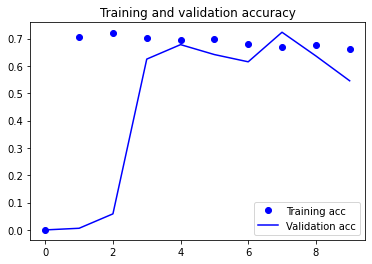

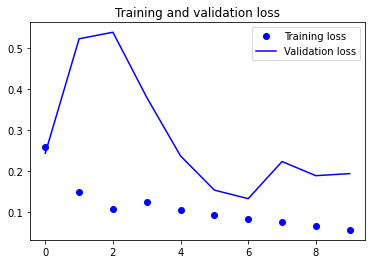

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluación:

In [37]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('test acc:', test_acc)

127/127 - 14s - loss: 0.1945 - accuracy: 0.5482 - 14s/epoch - 109ms/step
test acc: 0.5481719374656677


# Entrenar el modelo con size (32,32)

In [ ]:
with open('../data/x_train_32.npy', 'rb') as f:
    x_train = np.load(f)
with open('../data/y_train_32.npy', 'rb') as f:
    y_train = np.load(f)

In [ ]:
history = History()
callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ModelCheckpoint(filepath='../data/weights32.best.hdf5', verbose=1, save_best_only=True, 
                             save_weights_only=True, mode='auto')]

In [ ]:
conv_base = resnet.ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

In [ ]:
model2 = models.Sequential()
#model.add(BatchNormalization(input_shape=(82, 82,3)))
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(17, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
model2.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_val, y_val),
          callbacks = callbacks)

In [ ]:
test_loss, test_acc = model2.evaluate(x_test, y_test, verbose=2)
print('test acc:', test_acc)

# CONCLUSIONES:

In [ ]:
Como conclusiones,